# pyMLR

    A python package for MLR
    
    PRE-REQUISITES
        1. xarray
        2. salem
        3. geopandas
        4. dominance_analysis (https://github.com/dominance-analysis/dominance-analysis)
        5. statsmodels

In [60]:
from MLR import norm, norm_1D, norm_2D, mlr_out
from MLR import time_series_1D, time_series_2D, mlr_dominance, correlation_matrix, VIF
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import numpy as np
import salem

<AxesSubplot:>

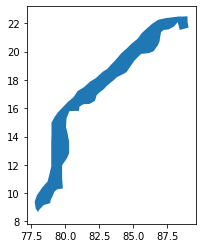

In [2]:
#define the time required for the analysis
time = pd.date_range('01-01-1981','12-01-2020', freq='MS')

#region selected for the study in geopandas dataframe converted to xarray
shp = gpd.read_file('/home/user/Desktop/shp/mon_hom/EC.shp')
shp.to_xarray()
shp.plot()

We can use normalized data and raw data for MLR using this package. 
Using normalised data, we can find the time series of anomaly of the data to be regressed. 

Both are described in this tutorial.

predictors

if the data is 3 dimensional, ie, "time, lat, lon", use norm_2D function to get the normalised 2D time series. Similarly, norm1D will give the normalised time series.

    norm_1D(path,time):
        path : give the path of the data
        time is already defined above, so just give "time" here. Else, use pandas date_range to add time.
    
    norm_2D(path, shapefile_xarray, time, dims):
        path: path of the data
        shapefile array : geopandas dataframe with shapefil. eg: shp
        dims: a spatial data should be averaged upon x and y axis to get the time series. Here, you have to 
        tell the function about the coordinates. EG: ['lat','lon']
        
for a simple time series using the data:

    time_series_1D(path,time) 
    time_series_2D(path, shapefile_xarray, time, dims):
can be used. Inputs to these function are the same as above.

<xarray.DataArray 'QV2M' (time: 510, lat: 71, lon: 57)>
[2063970 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 5.0 5.5 6.0 6.5 7.0 7.5 ... 38.0 38.5 39.0 39.5 40.0
  * lon      (lon) float64 64.38 65.0 65.62 66.25 ... 97.5 98.12 98.75 99.38
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2022-06-01
Attributes:
    long_name:       2-meter_specific_humidity
    units:           kg kg-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    origname:        QV2M
    fullnamepath:    /QV2M
    pyproj_srs:      +proj=longlat +datum=WGS84 +no_defs

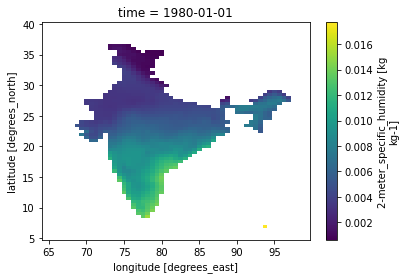

In [3]:
#humidity is a 3D function:
hum = xr.open_dataarray('MLR/SHUM.nc')
hum[0].plot()
hum

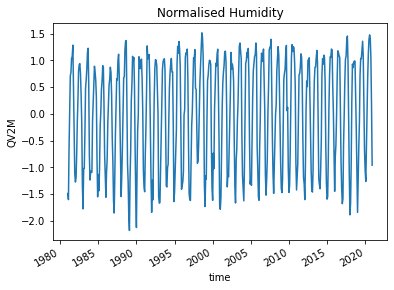

Text(0.5, 1.0, 'Humidity time series')

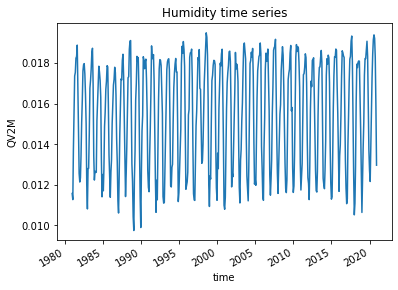

In [4]:
#to normalise
hum_normalised_time_series = norm_2D('MLR/SHUM.nc', shp, time,['lat','lon'])
hum_normalised_time_series.plot()
plt.title('Normalised Humidity')
plt.show()

#time_series
hum_time_series = time_series_2D('MLR/SHUM.nc', shp, time,['lat','lon'])
hum_time_series.plot()
plt.title('Humidity time series')

    if the input is a simple time series,

    norm_1D will give the normalised and time_series_1D will give the simple time series.

    For instance, let's use EHF to demonstrate this.

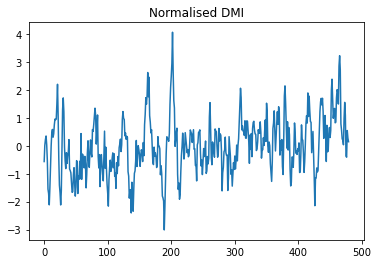

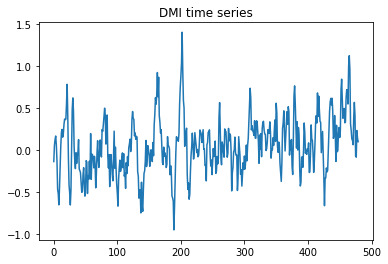

In [5]:
dmi_normalised = norm_1D('MLR/DMI.nc', time)
plt.plot(dmi_normalised)
plt.title('Normalised DMI')
plt.show()

dmi_time_series = time_series_1D('MLR/DMI.nc', time)
plt.plot(dmi_time_series)
plt.title('DMI time series')
plt.show()

# NORMALISED MLR

In [6]:
#dataset to be regressed
T = norm_1D('MLR/T_EC.nc', time)

In [48]:
#predictors
pred = [hum_normalised_time_series, dmi_normalised] #you can add more predictors here!!!!

    We need to check the collinearity of the predictors before using it to find the MLR. 
    We have included a correlation matrix for this.
    To use this, we the syntax is as follows:
    
    correlation matrix([list of predictors], [list of predictor names as str], path/to/save/the/figure/+filename, fontsize to be used for plotting the matrix, figure size in inches)
                        
    for instance:
    
    correlation_matrix([hum_normalised_time_series, dmi_normalised],['hum','dmi'], 'matrix.png', 12, (5,5))

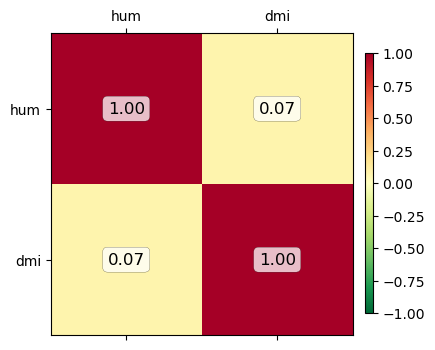

In [29]:
correlation_matrix([hum_normalised_time_series, dmi_normalised],['hum','dmi'], 'matrix.png', 12, (4,4))

    A variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. Mathematically, the VIF for a regression model variable is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable.
    
    syntax:
    VIF([list of predictors],[list of names of predictors in str])

In [50]:
VIF([hum_normalised_time_series, dmi_normalised],['hum','dmi'])

  feature       VIF
0     hum  1.004859
1     dmi  1.004859


# MLR

    The function to find the mlr fit is "mlr out", this should be written into a variable.
    
    Syntax:
    a = mlr_out(norm_y, norm_vars)
            where norm_y is the normalized data to be regressed and
                  norm_x in the list of normalised predictors.
                  
    Output:
    
    a[0]: MLR fit (time series)
    a[1]: Correlation coefficiants in the order of input.
    a[2]: Residual of MLR
    a[3]: R-squared
    a[4]: Adjusted R squared
    a[5]: Stat of the OLR
    
    
    

In [47]:
a = mlr_out(T, pred)


R_squared = 0.482
adj_Rsq = 0.48
 "om!"


# plots

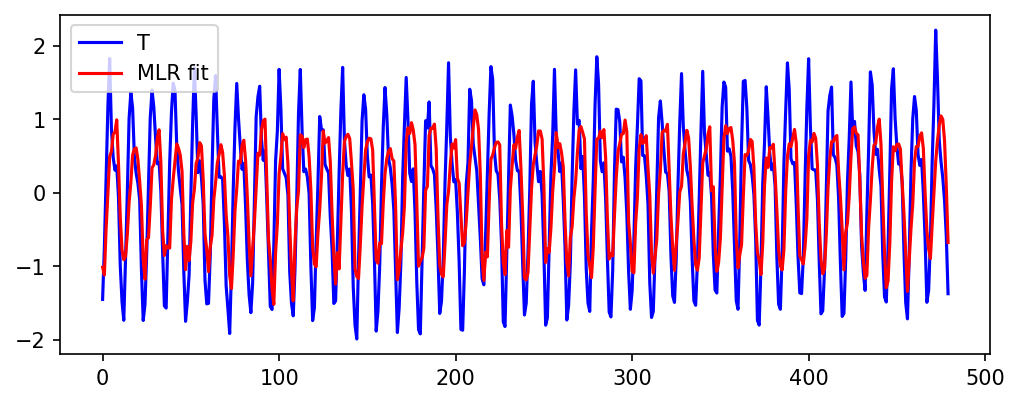

In [22]:
plt.figure(figsize=(8,3), dpi=150)
plt.plot(T, c='b', label='T')
plt.plot(res[0], c='r', label='MLR fit')
plt.legend()

# DOMINANCE OF EACH VARIABLES

    Azen and Budescu (2003) proposed using dominance analysis (DA) because it invokes a general and intuitive definition of "relative importance" that is based on the additional contribution of a predictor in all subset models. The purpose of determining predictor importance in the context of DA is not model selection but rather uncovering the individual contributions of the predictors.
    
    Syntax:
        mlr_dominance(norm_y, [list_of_predictors],[list of predictors name in str], mlr_out(norm_y [list_of_predictors])
    

In [58]:
xx = mlr_dominance(T,[hum_normalised_time_series, dmi_normalised],['hum','dmi'], mlr_out(T,[hum_normalised_time_series, dmi_normalised]))


R_squared = 0.482
adj_Rsq = 0.48
 "om!"
Selecting 2 Best Predictors for the Model
Selected Predictors :  ['hum', 'dmi']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.48209839744834615

Selecting 2 Best Predictors for the Model
Selected Predictors :  ['hum', 'dmi']

Creating models for 3 possible combinations of 2 features :


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 219.60it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|██████████████████████████████████████████| 1/1 [00:00<00:00, 16980.99it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################



In [59]:
xx #dominance of each variable out of 100%

[99.80293419910318, 0.21748020926739914]

# SUMMARY

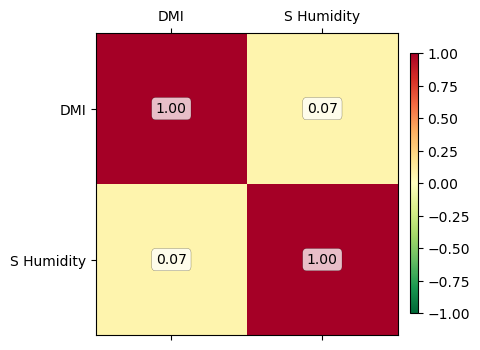


R_squared = 0.482
adj_Rsq = 0.48
 "om!"
Selecting 2 Best Predictors for the Model
Selected Predictors :  ['DMI', 'S Humidity']

********************  R-Squared of Complete Model :  ********************
R Squared : 0.48209839744834626

Selecting 2 Best Predictors for the Model
Selected Predictors :  ['DMI', 'S Humidity']

Creating models for 3 possible combinations of 2 features :


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 245.58it/s]


#########################  Model Training Done!!!!!  #########################

#########################  Calculating Variable Dominances  #########################


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 8594.89it/s]

#########################  Variable Dominance Calculation Done!!!!!  #########################

The relative dominance of each Term is:
DMI:0.21748020926741066
S Humidity:99.80293419910319


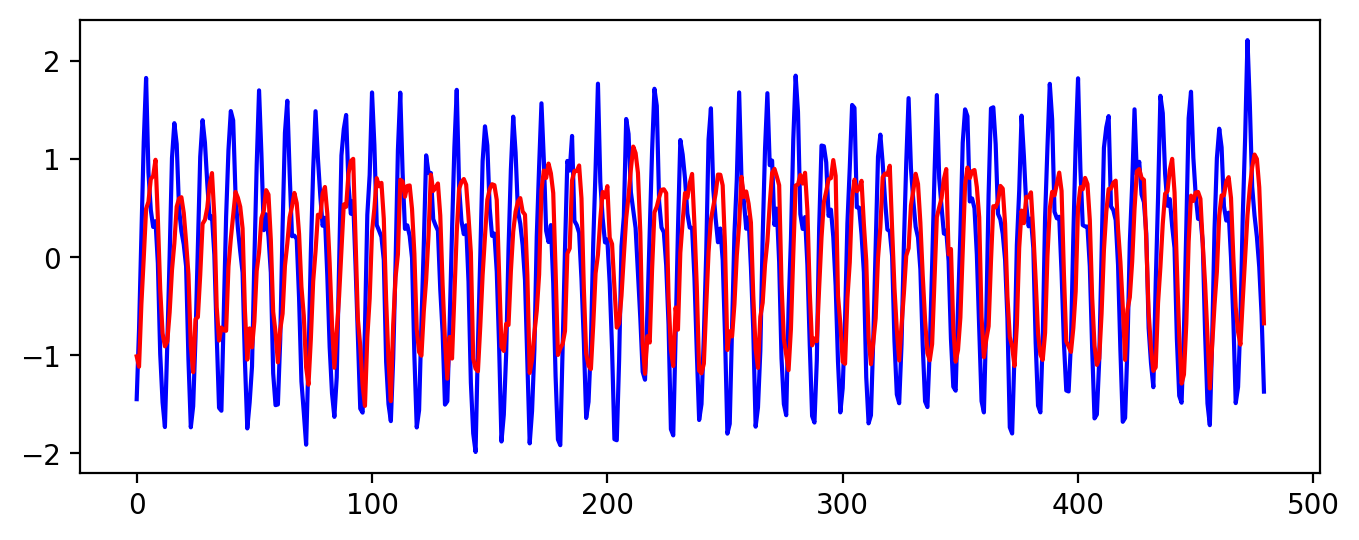

In [84]:
#time
time = pd.date_range('01-01-1981','12-01-2020', freq='MS')

#shapefile
shp = gpd.read_file('/home/user/Desktop/shp/mon_hom/EC.shp')
shp.to_xarray()

#data to regress
T = norm_1D('MLR/T_EC.nc',time)

#predictors
hum = norm_2D('MLR/SHUM.nc', shp, time,['lat','lon'])
dmi = norm_1D('MLR/DMI.nc',time)

pred = [dmi,hum]
pred_heads = ['DMI','S Humidity']

#multicollinearity
correlation_matrix(pred, pred_heads,'matrix.png',10,(4,4))
plt.show()


a = mlr_out(T, pred)

plt.figure(figsize=(8,3), dpi=200)
plt.plot(T, c='blue', label='T')
plt.plot(a[0], c='red', label='MLR Fit')

dominance = mlr_dominance(T, pred, pred_heads, a)

print('The relative dominance of each Term is:')
for i,j in enumerate(dominance):
    print(''+pred_heads[i]+':'+str(j)+'')